# Attachments

This notebook demonstrates how to use file attachments in a DataJoint table field. 

The attached files will be stored directly in the database. A separate notebook explains how to configure external storage in a filesystem, AWS S3, and others object storage systems.

In [1]:
# Author and date
import datetime, getpass
print(getpass.getuser(), datetime.datetime.today())

import datajoint as dj
print('DataJoint Version', dj.__version__)

dimitri 2019-11-03 18:27:41.690342
DataJoint Version 0.12.1


### Find a test fie
We need a couple of images to work with. Let's get an arbitrary image from Wikipedia:

In [2]:
import requests 

image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Pioneer_plaque.svg/606px-Pioneer_plaque.svg.png"
local_image_file = image_url.split('/')[-1]

# download the file 
import requests
with open(local_image_file, 'wb') as f:
    f.write(requests.get(image_url).content)

print("Downloaded", local_image_file)

Downloaded 606px-Pioneer_plaque.svg.png


To verify, display the image

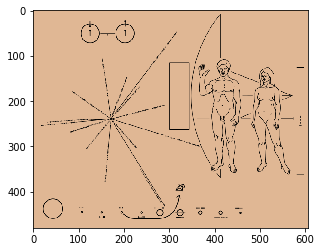

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import imageio
plt.imshow(imageio.imread(local_image_file))

Now let's create a new DataJoint schema for this demo

In [4]:
# create a schema for this demo
schema = dj.schema('test_attach_simple')

Connecting dimitri@localhost:3306


Let's declare table `Image` storing images as files

In [5]:
@schema
class Image(dj.Manual):
    definition = """
    image_number : int
    ---
    image_description : varchar(255) 
    image_file  : attach         # a file attachment stored internally in the table
    """

### inserting
Then we simply insert the image fie referencing it with the path.

In [6]:
Image.insert1((1, 'Pioneer 10 plaque', local_image_file))

In [7]:
# View table contents
Image()

image_number,image_description,image_file a file attachment stored internally in the table
1,Pioneer 10 plaque,=BLOB=


### fetching

Let's remove the local file and fetch from the database.

In [8]:
import os
os.remove(local_image_file)

In [9]:
# verify that the file is gone
try:
    imageio.imread(local_image_file)
except FileNotFoundError:
    print("The file is indeed gone")

The file is indeed gone


In [10]:
result = Image.fetch(as_dict=True)
result

[{'image_number': 1,
  'image_description': 'Pioneer 10 plaque',
  'image_file': '606px-Pioneer_plaque.svg.png'}]

The file is downloaded in the local folder by default and its path is returned in the fetch result. Let's verify:

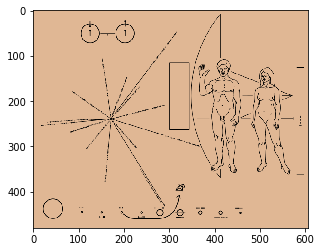

In [11]:
plt.imshow(imageio.imread(result[0]['image_file']))

You can specify an explicit path to download the attachments using the `download_path` keyword argument:

In [12]:
os.makedirs('./temp', exist_ok=True)
result = Image.fetch(download_path='./temp')

Note that DataJoint will not create a second copy of the attached file if the contents of the file is unchanged. But a different file with the same name already exists, it will create a new name for the attached file:

In [13]:
downloaded_file = (Image & {'image_id': 1}).fetch1('image_file')
downloaded_file

'606px-Pioneer_plaque.svg.png'

In [14]:
downloaded_file = (Image & {'image_id': 1}).fetch1('image_file')
downloaded_file

'606px-Pioneer_plaque.svg.png'

In [15]:
with open(downloaded_file, 'w') as f:
    f.write('different contents')

In [16]:
downloaded_file = (Image & {'image_id': 1}).fetch1('image_file')
downloaded_file

'606px-Pioneer_plaque.svg_0000.png'

I will keep incrementing the suffix everytime a files with unique contents are downloaded. We recommend using diverse names for attached files to avoid the overhead of checking the contents of the downloaded files.

That's all!  

In [17]:
schema.drop() # cleaup

Proceed to delete entire schema `test_attach_simple`? [yes, No]: yes


Sorry we left some image image files behind in the current folder.